## Baseball Stats

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy import stats

#from fangraphs import fangraph
import bb_stat_utils
from IPython.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Run this cell to generate the SQLLite DB. 
# This may take a while (~30 mins)
#fangraph.generate_sqllite_tables()

In [3]:
# Point to the SQLLTIE Db
db_path = r'/home/zach/dev/demos/baseball_stats/2021_Baseball-final.db'
conn = sql.connect(db_path)

# Sanitizing Data
The batting and pitching data is individual game level stats. 
Here we cast all basic stats as integers, as they are all strings in the database.
Note the casting will error and be ignored, (ie do nothing) on non integer data, such as batting average, ERA, slugging percentage etc.
These statistics, when of interest, are rederived later, from the raw data. 
We also turn the date string into a much more useful datetime object. 

## A Note on Innings Pitched
For some reason, baseball stores fractional innings as .1 = 1/3 . Similiar to a base 3 system, but only for the decimal. so 3.1 innings is 3 1/3 innings in base 10. 


In [4]:
import os
os.path.exists(db_path)

True

In [5]:
# Clean Batting Data
batting_df = pd.read_sql('SELECT * FROM bat', con=conn)
for col in batting_df.columns:
    batting_df[col] = batting_df[col].astype('int', errors='ignore')
batting_df['Datetime'] = pd.to_datetime(batting_df['Date'], format="%Y-%m-%d")

In [6]:
# Clean Position Data (Games Played at Each Position)
# make a column for each position and count the games played at the position
# prepend an f to each position to incidate its a fielding stat and avoid conflating Singles (1B) with the first base position
unique_pos = []
for dashed_pos in batting_df.Pos.unique():
    [ unique_pos.append('f' + pos) for pos in dashed_pos.split('-') if 'f' + pos not in unique_pos]
batting_df[unique_pos] = 0

for pos in unique_pos:
    batting_df.loc[batting_df['Pos'] == pos[1::], pos] = 1

# Add Aggregate Positions (Like RF/CF/LF) being interchangeable
batting_df['fOF'] = batting_df[['fRF', 'fCF', 'fLF']].sum(axis=1)
unique_pos.append('fOF')

In [7]:
# Sanity Check (Tatis Played Games at SS, RF, CF, DH)
batting_df.loc[batting_df['name'].str.contains('tatis-jr'), unique_pos].sum()

f2B      0
fSS    101
fPH      4
f1B      0
fDH      1
f3B      0
fRF     16
fCF      4
fLF      0
fP       0
fC       0
fPR      0
fOF     20
dtype: int64

In [8]:
# Aggregate Batting Data for a Full Season
batting_df_sum = batting_df.groupby(['id', 'name']).sum()

In [9]:
# Clean Pitching Data
pitching_df = pd.read_sql('SELECT * FROM pit', con=conn)
for col in pitching_df.columns:
    pitching_df[col] = pitching_df[col].astype('int', errors='ignore')

pitching_df['IP'] = pitching_df['IP'].apply(lambda x: bb_stat_utils.IP_basis_conversion(x))
pitching_df_sum = pitching_df.groupby('name').sum()
pitching_df['Datetime'] = pd.to_datetime(pitching_df['Date'], format="%Y-%m-%d")

In [10]:
# Calculate 'advanced', non integer metrics for the full season,
#  these functions are applied in place
bb_stat_utils.calc_SLUG_TOT(batting_df_sum)
bb_stat_utils.calc_WHIP_TOT(pitching_df_sum)

# TOPSIS

0.038491651631186674 0.04408309120292453


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
16252,trea-turner,28,77,242,32,319,0.780559,0.166239,0.698816
16556,ozzie-albies,30,106,213,20,307,0.946798,0.001044,-0.204849
12533,marcus-semien,45,102,242,15,351,0.947842,0.221297,1.000000
12979,javier-baez,31,87,174,18,248,1.169139,0.048239,0.053321
13152,jorge-polanco,33,98,208,11,296,1.217378,0.104288,0.359927
18882,brandon-lowe,39,99,209,7,280,1.321666,0.001246,-0.203743
11281,whit-merrifield,10,74,228,40,262,1.322913,0.141866,0.565489
5417,jose-altuve,31,83,237,5,294,1.464779,0.016373,-0.120997
19470,tommy-edman,11,56,212,30,248,1.481151,0.024778,-0.075016


0.05053206226832669 0.055537312898728874


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
19709,fernando-tatis-jr,42,97,199,25,292,0.426348,0.117648,0.245473
19612,bo-bichette,29,102,237,25,310,0.543996,0.047326,-0.011726
16252,trea-turner,28,77,242,32,319,0.591322,0.323946,1.000000
12979,javier-baez,31,87,174,18,248,0.915268,0.074947,0.089298
12564,trevor-story,24,75,196,20,248,0.990215,0.023466,-0.098994
13152,jorge-polanco,33,98,208,11,296,1.013681,0.178366,0.467547
5343,brandon-crawford,24,90,205,11,252,1.192046,0.019564,-0.113265
18314,dansby-swanson,27,88,203,9,264,1.211610,0.076079,0.093436
15172,tim-anderson,17,61,186,18,247,1.287689,0.081604,0.113644


0.0866047448268751 0.17876751210174896


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
2967,tommy-pham,15,49,191,14,182,0.545970,1.120541,1.000000
12775,brad-miller,20,49,121,3,150,1.666511,0.129715,0.041695
5827,wilmer-flores,18,53,146,1,174,1.796226,0.054967,-0.030600
15653,dominic-smith,11,58,150,2,162,1.851193,0.044377,-0.040842
9929,darin-ruf,16,43,120,2,136,1.895569,0.083071,-0.003417
10815,jurickson-profar,4,33,135,10,113,1.978641,0.062319,-0.023488
1177,albert-pujols,17,50,84,2,119,2.040960,0.140605,0.052228
17988,tyler-stephenson,10,45,147,0,151,2.181565,0.036748,-0.048220
27506,ha-seong-kim,8,34,80,6,94,2.218313,0.036038,-0.048907


0.054393684962678435 0.05321171532971637


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
9218,paul-goldschmidt,31,99,248,12,310,0.674040,0.256713,1.000000
5361,freddie-freeman,31,83,273,8,302,0.930753,0.121401,0.331197
19611,vladimir-guerrero-jr,48,111,280,4,363,1.052154,0.081742,0.135176
14344,matt-olson,39,111,250,4,305,1.133897,0.220175,0.819407
19251,pete-alonso,37,94,219,3,291,1.354072,0.057685,0.016267
18373,ryan-mountcastle,33,89,181,4,260,1.411757,0.008895,-0.224886
19566,nate-lowe,18,72,229,8,231,1.420652,0.090344,0.177690
13301,max-muncy,36,94,218,2,262,1.510996,0.076543,0.109477
3473,anthony-rizzo,22,61,198,6,218,1.587539,0.007009,-0.234208


0.15005402895900927 0.2633746666677942


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
19755,shohei-ohtani,46,100,238,26,318,0.567945,1.255578,1.000000
15640,aaron-judge,39,98,236,6,299,1.823523,0.005098,-0.131120
19611,vladimir-guerrero-jr,48,111,280,4,363,1.828621,0.313822,0.148136
7304,salvador-perez,48,121,210,1,337,2.142443,0.077143,-0.065952
14274,mitch-haniger,39,100,220,1,301,2.219586,0.025051,-0.113071
18373,ryan-mountcastle,33,89,181,4,260,2.244637,0.067853,-0.074355
15672,austin-meadows,27,106,186,4,237,2.312490,0.000157,-0.135589
19556,yordan-alvarez,33,104,207,1,285,2.312647,0.004082,-0.132039
2434,nelson-cruz,32,86,194,3,255,2.316729,0.097924,-0.047154


0.051877439945306934 0.11067184487836097


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
13510,jose-ramirez,36,103,226,27,297,0.226935,0.800026,1.000000
11493,manny-machado,28,106,222,12,276,1.026961,0.286611,0.313753
17350,rafael-devers,38,113,234,5,318,1.313573,0.043961,-0.010581
15429,kris-bryant,25,73,207,10,247,1.357534,0.155142,0.138026
9785,kyle-seager,35,101,191,3,264,1.512675,0.019682,-0.043033
9777,nolan-arenado,34,105,204,2,293,1.532357,0.011124,-0.054473
15112,ryan-mcmahon,23,86,197,6,237,1.543481,0.050332,-0.002065
5235,justin-turner,27,87,221,3,251,1.593813,0.032963,-0.025281
18360,austin-riley,33,107,243,0,313,1.626777,0.039656,-0.016335


0.030595441864326303 0.028994823186761387


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
11579,bryce-harper,35,84,256,13,300,0.921385,0.065733,0.374538
18345,kyle-tucker,30,92,203,14,282,0.987118,0.002538,-0.299068
13066,teoscar-hernandez,32,116,206,12,288,0.989656,0.001112,-0.314271
19287,adolis-garcia,31,90,178,16,264,0.990768,0.060412,0.317822
5254,robbie-grossman,23,67,239,20,231,1.051180,0.036927,0.067488
20123,juan-soto,29,95,304,9,268,1.088107,0.032640,0.021793
19290,randy-arozarena,20,69,215,20,243,1.120747,0.062885,0.344186
15640,aaron-judge,39,98,236,6,299,1.183633,0.107017,0.814597
15429,kris-bryant,25,73,207,10,247,1.290650,0.039464,0.094535


0.03815202701055044 0.05241843160185053


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
17929,cedric-mullins-ii,30,59,242,30,312,0.807896,0.379935,1.000000
19287,adolis-garcia,31,90,178,16,264,1.187831,0.129415,0.267020
9241,starling-marte,12,55,200,47,213,1.317246,0.131557,0.273288
13757,chris-taylor,20,73,200,13,222,1.448803,0.037888,-0.000772
19326,bryan-reynolds,24,90,252,5,292,1.486692,0.112187,0.216613
17919,ian-happ,25,66,172,9,202,1.598878,0.117413,0.231904
18564,trent-grisham,15,62,172,13,191,1.716291,0.050463,0.036020
22168,akil-baddoo,13,55,152,18,180,1.766754,0.034211,-0.011531
20126,dylan-carlson,18,65,212,2,237,1.800965,0.004947,-0.097152


0.02906927040425316 0.0329614680853361


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
13066,teoscar-hernandez,32,116,206,12,288,0.614267,0.015605,-0.097993
15711,tyler-oneill,34,80,189,15,270,0.629872,0.166470,1.000000
5254,robbie-grossman,23,67,239,20,231,0.796342,0.048728,0.143076
19290,randy-arozarena,20,69,215,20,243,0.845070,0.128420,0.723070
15429,kris-bryant,25,73,207,10,247,0.973490,0.089975,0.443271
14128,joey-gallo,38,77,216,6,228,1.063465,0.029845,0.005647
10950,adam-duvall,38,113,156,5,252,1.093311,0.059874,0.224197
9847,andrew-mccutchen,27,80,192,6,214,1.153185,0.002115,-0.196175
17919,ian-happ,25,66,172,9,202,1.155299,0.008572,-0.149178


0.005366248198806379 0.026376085590475485


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
15038,german-marquez,1,9,14,0,22,2.505159,0.422624,1.000000
17995,logan-webb,1,7,8,0,13,2.927783,0.222481,0.520336
4930,jon-lester,1,3,10,0,13,3.150264,0.107212,0.244082
13743,max-fried,0,5,19,0,18,3.257475,0.000997,-0.010471
14765,julio-urias,0,9,13,0,14,3.258472,0.091240,0.205806
19316,eric-lauer,1,4,8,0,7,3.349712,0.096839,0.219224
12718,adrian-houser,2,2,5,0,9,3.446552,0.024043,0.044760
13431,marcus-stroman,0,1,9,1,7,3.470594,0.120923,0.276943
8779,wade-miley,0,3,13,0,13,3.591517,0.020060,0.035214


0.03622604668152294 0.05559807068068904


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
11739,jt-realmuto,17,73,184,13,209,1.784098,0.138067,0.347369
7304,salvador-perez,48,121,210,1,337,1.922165,0.290987,0.868963
19197,will-smith,25,76,183,3,205,2.213152,0.102967,0.227647
11609,willson-contreras,21,57,164,5,181,2.316119,0.329404,1.000000
9774,christian-vazquez,6,49,153,8,161,2.645523,0.108797,0.247531
13265,mike-zunino,33,62,113,0,186,2.754320,0.007698,-0.097308
14111,eric-haase,22,61,109,2,161,2.762017,0.008527,-0.094478
7007,yadier-molina,11,66,140,3,163,2.770544,0.081945,0.155944
9166,buster-posey,18,56,177,0,197,2.852490,0.015797,-0.069680


0.008275361912918005 0.01186076810589391


,,HR,RBI,OB_TOT,SB,SLUG_TOT,distance_from_ideals,improvement,pick_value
id,name,,,,,,,,
17929,cedric-mullins-ii,30,59,242,30,312,0.725438,0.121256,1.000000
11579,bryce-harper,35,84,256,13,300,0.846694,0.039184,0.273571
13066,teoscar-hernandez,32,116,206,12,288,0.885878,0.007640,-0.005624
18345,kyle-tucker,30,92,203,14,282,0.893518,0.008870,0.005265
19287,adolis-garcia,31,90,178,16,264,0.902388,0.009143,0.007683
15711,tyler-oneill,34,80,189,15,270,0.911532,0.021115,0.113644
20123,juan-soto,29,95,304,9,268,0.932647,0.010676,0.021247
5254,robbie-grossman,23,67,239,20,231,0.943322,0.027632,0.171328
15640,aaron-judge,39,98,236,6,299,0.970955,0.016860,0.075984


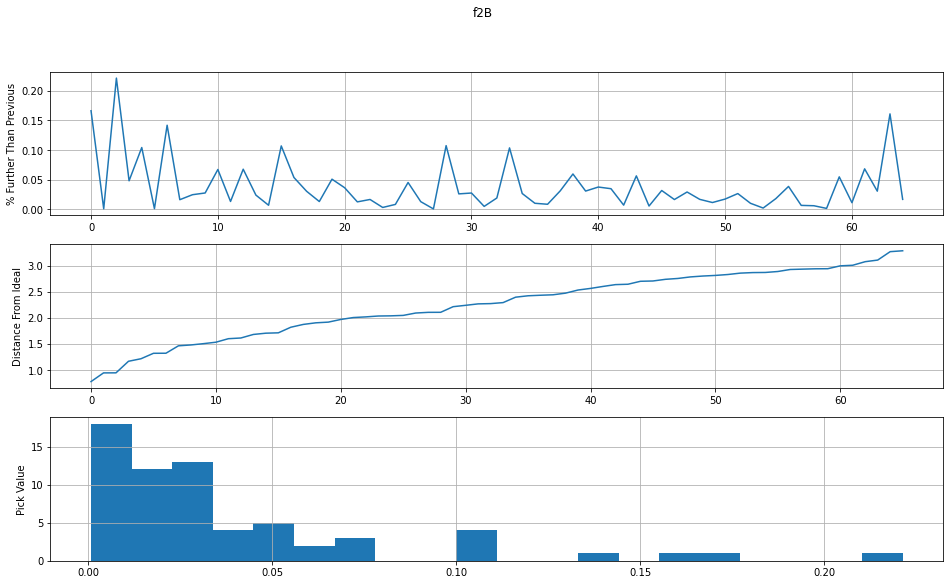

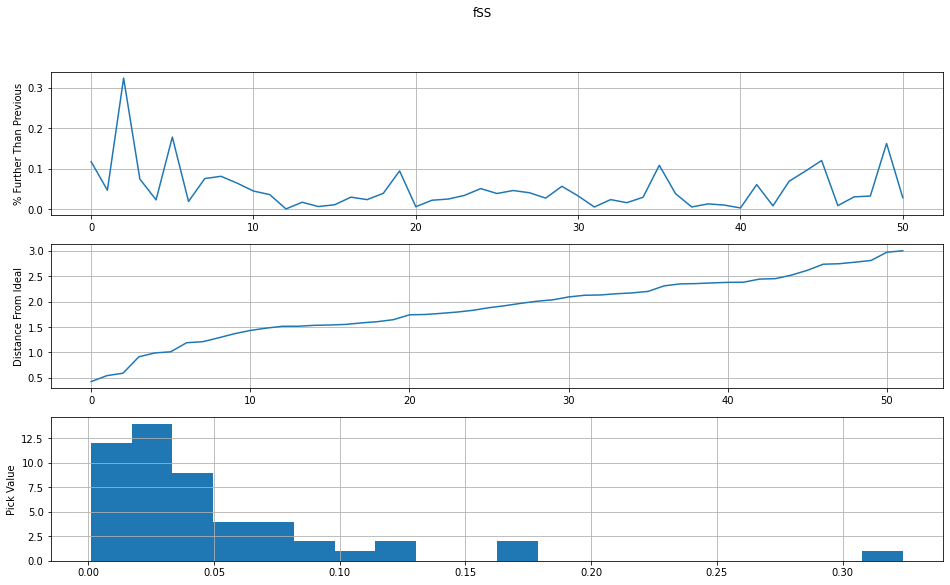

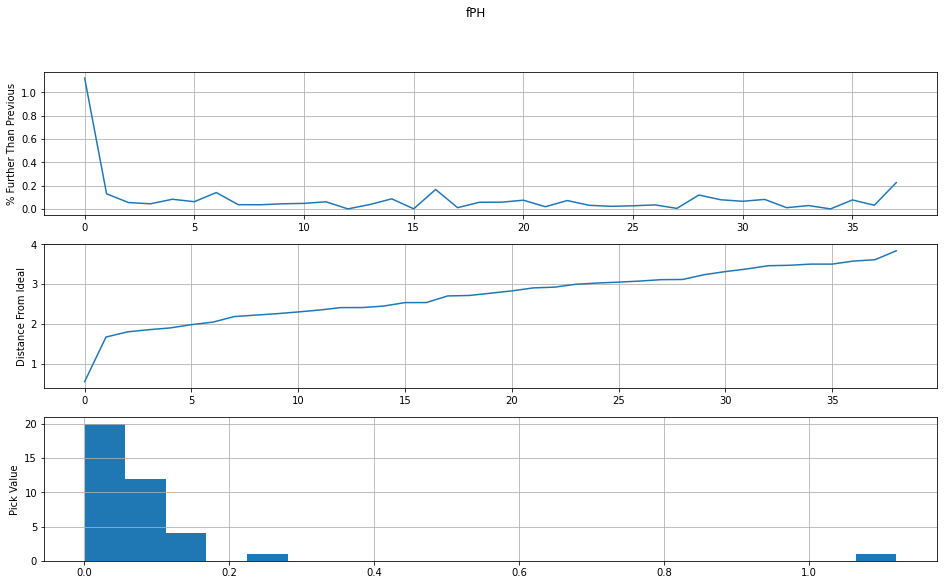

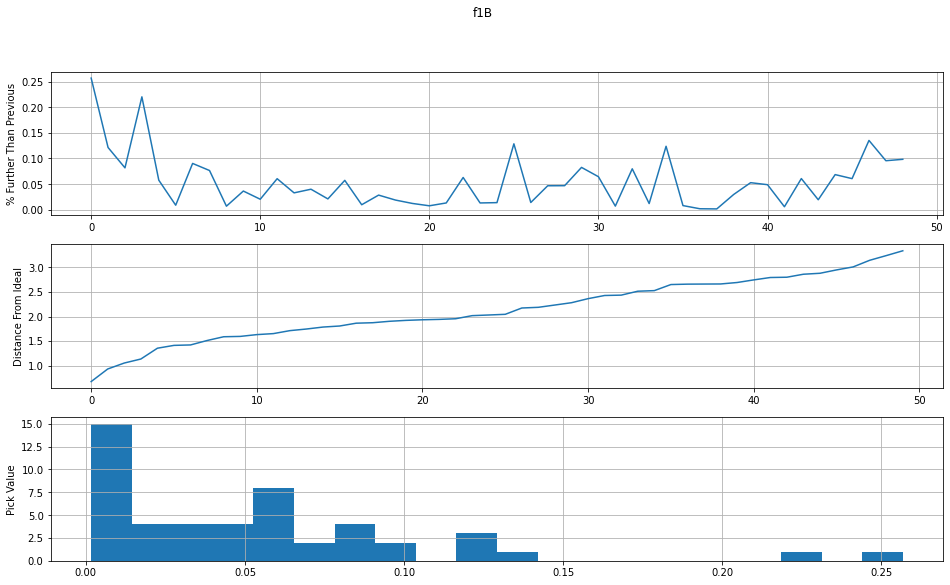

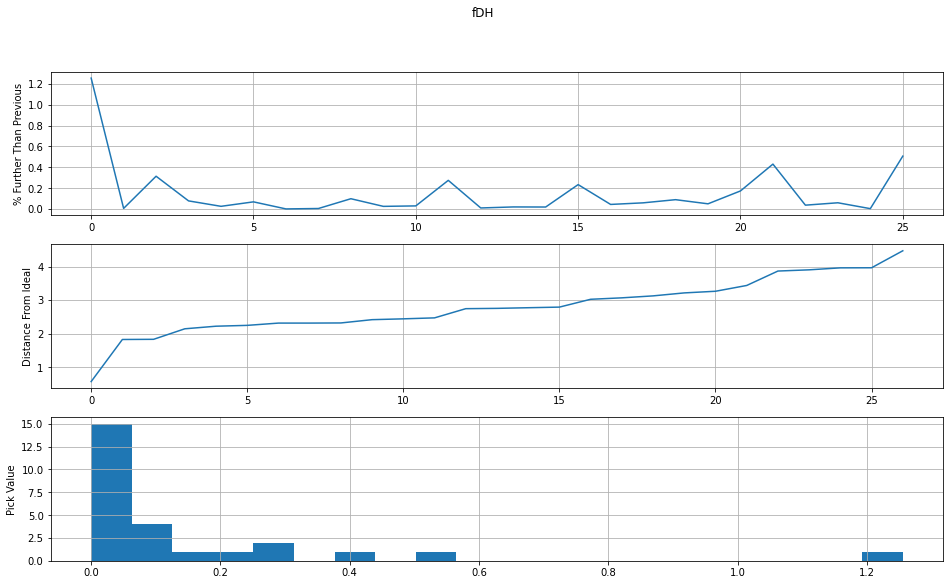

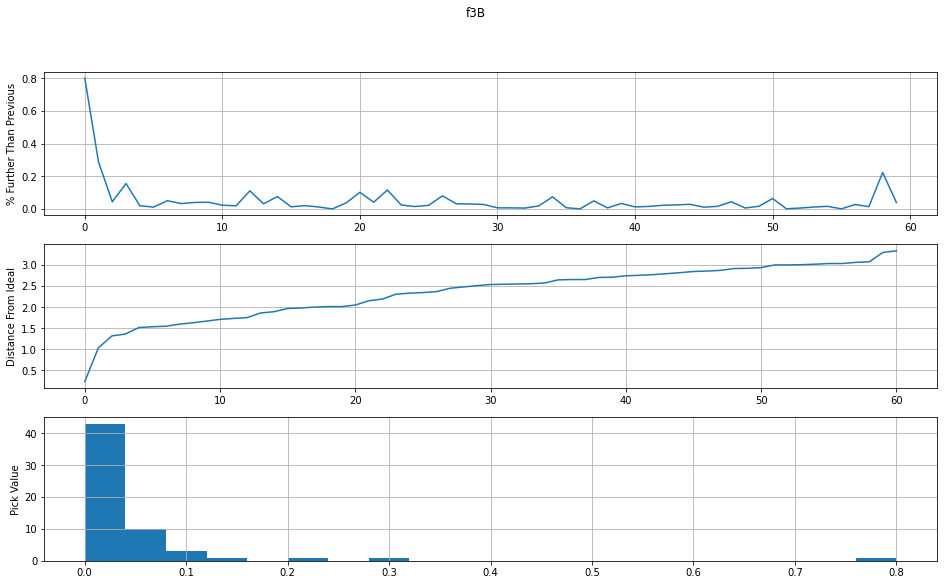

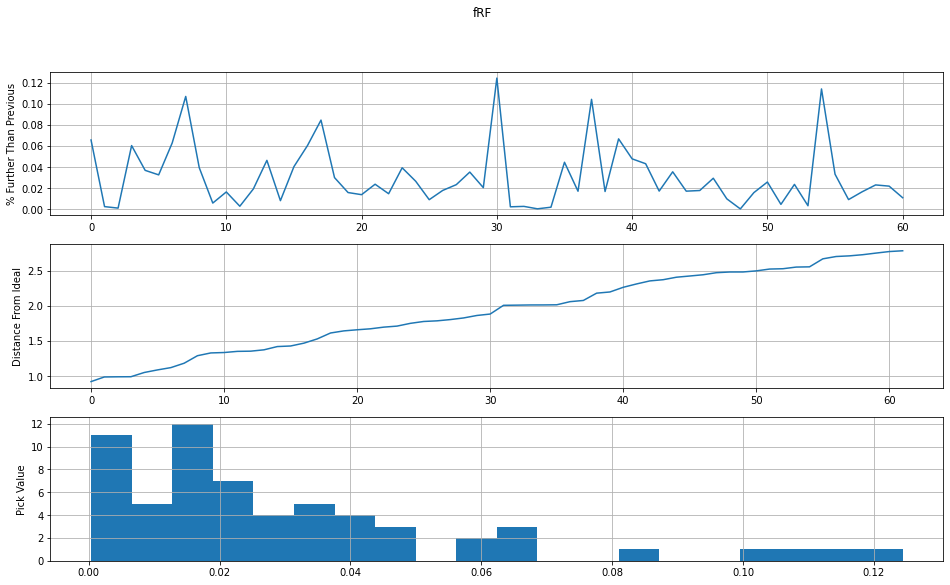

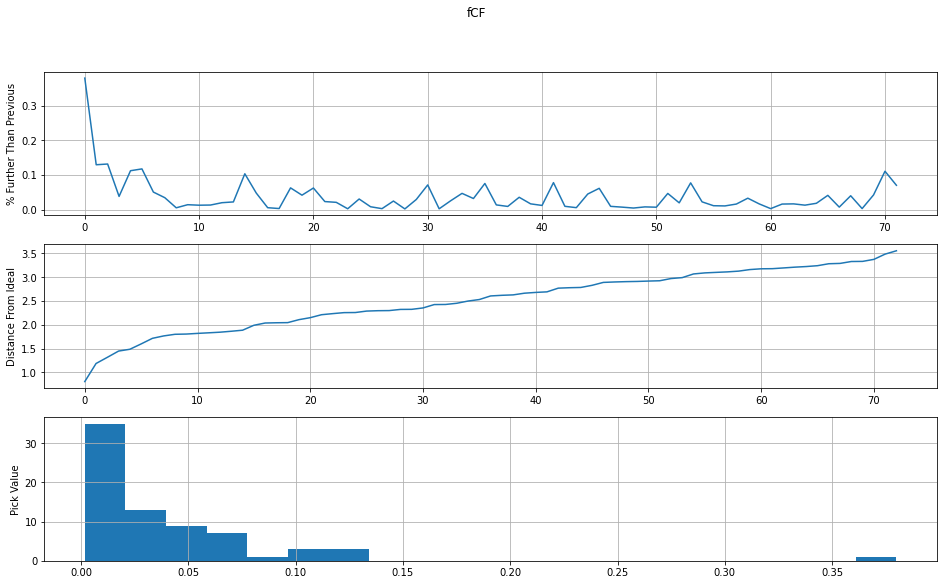

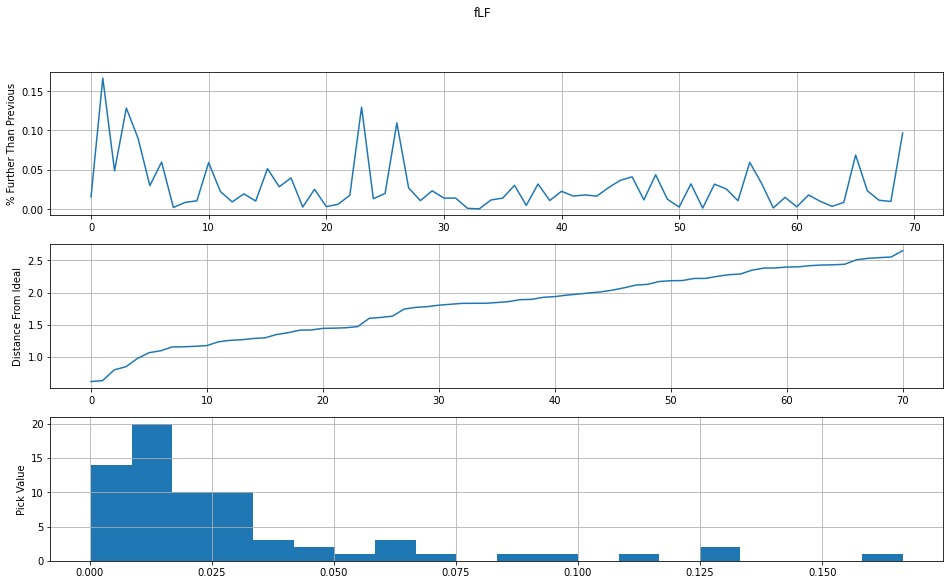

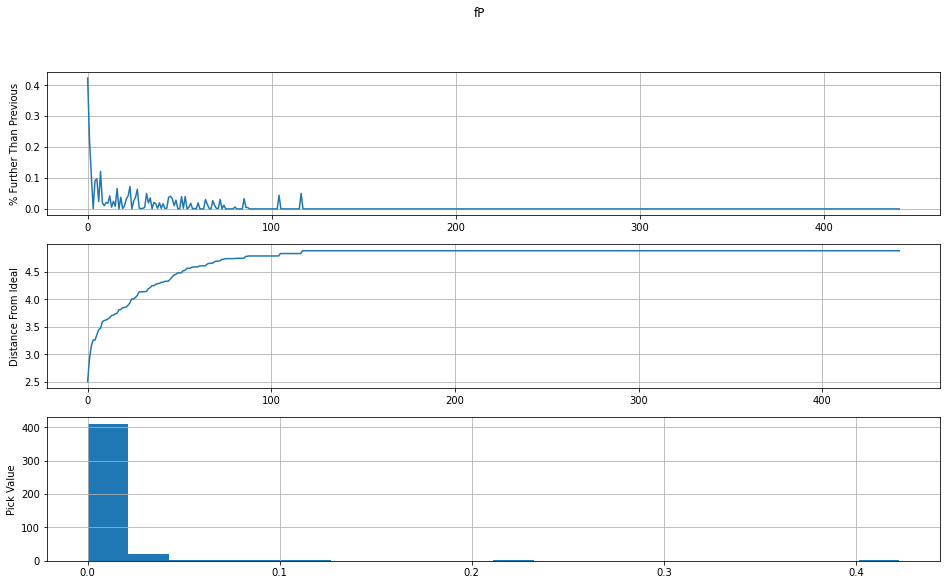

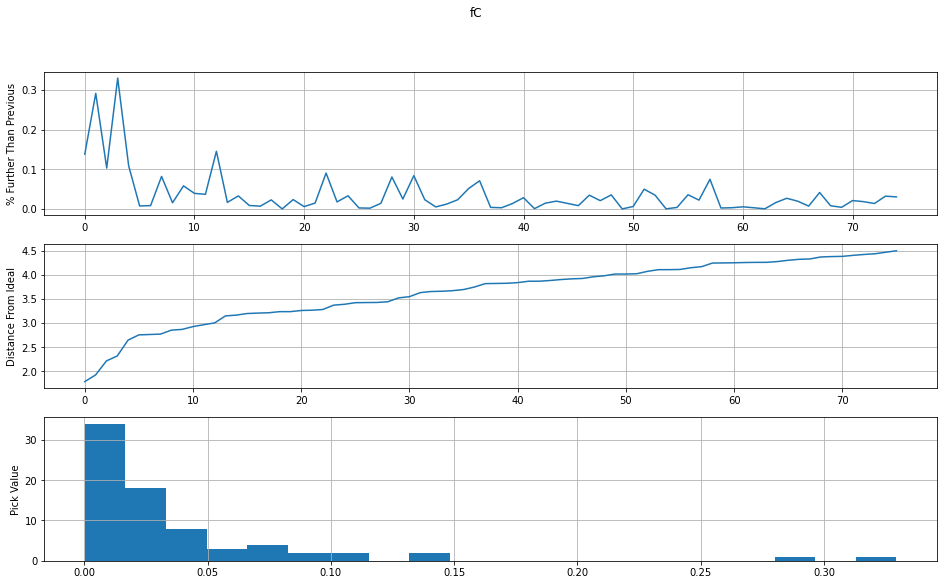

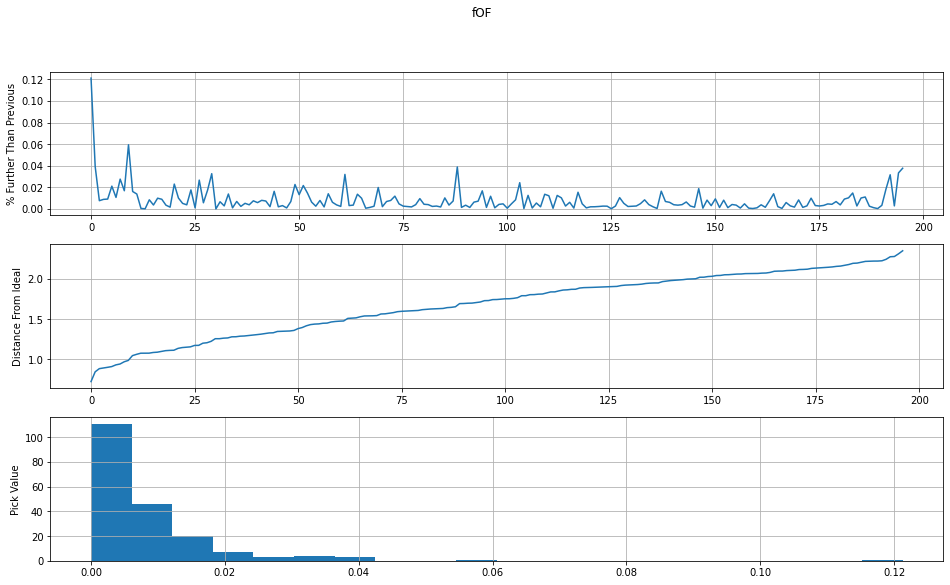

In [13]:
cats = ['HR', 'RBI', 'OB_TOT', 'SB', 'SLUG_TOT']
cats_power = {key: 1.0 for key in cats}

min_games_played_at_pos = 20
for pos in unique_pos:
    mask = (batting_df_sum[pos] > min_games_played_at_pos)
    sub_df = batting_df_sum.loc[mask,:].copy()
    if len(sub_df) > 0:
        score_df = bb_stat_utils.topsis(df=sub_df, cats=cats, cats_power=cats_power,  csv_name=None)
        bb_stat_utils.determine_pick_value(score_df)
        display(HTML(f'<h1>{pos}</h1><b>' + score_df.iloc[:10][cats + ['distance_from_ideals', 'improvement', 'pick_value']].to_html()+'<\b>'))
        
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,9))
        fig.suptitle(pos)
        ax[1].plot(score_df['distance_from_ideals'].values)
        ax[1].set_ylabel('Distance From Ideal')
        ax[0].plot(score_df['improvement'].values)
        ax[0].set_ylabel('% Further Than Previous')
        ax[2].hist(score_df['improvement'].values, bins=20)
        ax[2].set_ylabel('Pick Value')
        ax[0].grid()
        ax[1].grid()
        ax[2].grid()
        

In [12]:
cats = ['ER', 'QS_STAND', 'SV', 'WH_TOT', 'SO', 'IP']
cats_power = {'ER': -1.0, 'QS_STAND': 1.0, 'SV': 1.0, 'WH_TOT': -1.0, 'SO': 1.0, 'IP' : 1.0}
score_df = bb_stat_utils.topsis(df=pitching_df_sum, cats=cats, cats_power=cats_power, csv_name=None)
display(HTML(f'<h1>Pitching</h1>' + score_df.iloc[:5][cats + ['distance_from_ideals']].to_html()))


,ER,QS_STAND,SV,WH_TOT,SO,IP,distance_from_ideals
name,,,,,,,
walker-buehler,57,29,0,201,212,207.666667,0.624473
kevin-gausman,60,27,0,200,227,192.000000,0.624519
robbie-ray,61,25,0,203,248,193.333333,0.626315
charlie-morton,69,27,0,194,216,185.666667,0.629479
max-scherzer,49,26,0,155,236,179.333333,0.629545
